In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import mra 
import selector as se 

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)
random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 10
eps_sublevel = percent = 0.1

num_agents = num_commodities = 100

filename = "subgrad_mcf_N%d_%.2f_n%d"%(num_points, eps_sublevel, num_agents)

In [4]:
num_vertices = 15
num_edges = 100

params, A_ineq, b_ineq = mra.mcf_data(num_vertices, num_edges, num_commodities)

In [5]:
b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [6]:
true_x, true_f, true_lamb = mra.centralized_multi_commodity_flow(params, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=-127.24864071513177


In [7]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

0.999999999919178

In [8]:
true_lamb.shape, true_x.shape

((100, 1), (10000, 1))

In [9]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.mcf_query_multiple_actions(lamb_k, i, params[i], 
                                                                           eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.mcf_query_multiple_actions_noisy_prices(lamb_k, i, params[i], percent=percent, K=K)]

fun_obj_val = lambda x_k: mra.mcf_obj_value(x_k, params)

# Dual subgradient

In [10]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()

K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

### Best learning schedule

In [11]:
alpha_ks = ["0.1/sqrt(k)", "1/sqrt(k)", "1/k", "10/k"]
func_alphas = {"0.1/sqrt(k)": lambda k: 0.1 / np.sqrt(k+1), 
               "1/sqrt(k)": lambda k: 1 / np.sqrt(k+1),
               "1/k": lambda k: 1 / (k+1),
               "10/k": lambda k: 10 / (k+1)}

best_schedule = [np.inf, "0.1/sqrt(k)"] 

for alpha_k, func_alpha_k in func_alphas.items():
    print(f"{alpha_k=}")
    all_results = mra.dual_proj_subgradient(fun_agents_eps, fun_obj_val, primal_var_size,
                                                             func_alpha_k, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=1, num_iters=20, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]

    if all_results["viol_primal_paver_xk"][-1] < best_schedule[0]:
        best_schedule = [all_results["viol_primal_paver_xk"][-1], alpha_k]

alpha_k='0.1/sqrt(k)'


/Users/tepars/anaconda3/envs/py311/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)
/Users/tepars/anaconda3/envs/py311/lib/python3.11/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/tepars/Documents/postdoc/mra_precovery/mra

epoch=0, f_subopt_xk=6.9833E-01,  f_subopt_mra=6.9833E-01,  viol_xk=2.8791E+02, viol_mra=2.8791E+02, lamb_rel_diff=INF
epoch=19, f_subopt_xk=2.1781E-01,  f_subopt_mra=2.1781E-01,  viol_xk=1.0172E+02, viol_mra=1.0172E+02, lamb_rel_diff=3.8102E-01
alpha_k='1/sqrt(k)'
epoch=0, f_subopt_xk=6.9833E-01,  f_subopt_mra=6.9833E-01,  viol_xk=2.8791E+02, viol_mra=2.8791E+02, lamb_rel_diff=INF
epoch=19, f_subopt_xk=2.2241E-01,  f_subopt_mra=2.2241E-01,  viol_xk=8.8301E+02, viol_mra=8.8301E+02, lamb_rel_diff=8.9803E-01
alpha_k='1/k'
epoch=0, f_subopt_xk=6.9833E-01,  f_subopt_mra=6.9833E-01,  viol_xk=2.8791E+02, viol_mra=2.8791E+02, lamb_rel_diff=INF
epoch=19, f_subopt_xk=1.0621E-01,  f_subopt_mra=1.0621E-01,  viol_xk=1.1557E+02, viol_mra=1.1557E+02, lamb_rel_diff=7.5344E-02
alpha_k='10/k'
epoch=0, f_subopt_xk=6.9833E-01,  f_subopt_mra=6.9833E-01,  viol_xk=2.8791E+02, viol_mra=2.8791E+02, lamb_rel_diff=INF
epoch=19, f_subopt_xk=2.8001E-01,  f_subopt_mra=2.8001E-01,  viol_xk=3.6862E+03, viol_mra=3.68

In [12]:
best_alpha_k = best_schedule[1]
print(f"{best_alpha_k=}")
func_alpha_k = func_alphas[best_alpha_k]

best_alpha_k='0.1/sqrt(k)'


In [13]:
all_results_eps, lamb_k_eps, _, x_k, _, mra_xk_eps  = mra.dual_proj_subgradient(fun_agents_eps, fun_obj_val, primal_var_size, func_alpha_k, 
                                                                                             A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=150, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)


all_results_noisy_y, lamb_k_eps, _, x_k, _, mra_xk_noisy_y  = mra.dual_proj_subgradient(fun_agents_noisy_y, fun_obj_val, primal_var_size, func_alpha_k, 
                                                                                             A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=150, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)

epoch=0, f_subopt_xk=6.9833E-01,  f_subopt_mra=6.0903E-01,  viol_xk=2.8791E+02, viol_mra=2.7424E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=6.3677E-02,  f_subopt_mra=7.6737E-02,  viol_xk=9.7630E+01, viol_mra=5.0569E+01, lamb_rel_diff=2.0485E-02
epoch=100, f_subopt_xk=2.5746E-02,  f_subopt_mra=3.2039E-02,  viol_xk=7.7015E+01, viol_mra=5.5723E+01, lamb_rel_diff=2.9346E-01
epoch=149, f_subopt_xk=1.4460E-02,  f_subopt_mra=3.0856E-02,  viol_xk=6.8687E+01, viol_mra=4.4719E+01, lamb_rel_diff=1.2153E-02
epoch=0, f_subopt_xk=6.9833E-01,  f_subopt_mra=6.7417E-01,  viol_xk=2.8791E+02, viol_mra=2.8449E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=6.3677E-02,  f_subopt_mra=6.8782E-02,  viol_xk=9.7630E+01, viol_mra=4.9913E+01, lamb_rel_diff=2.0485E-02
epoch=100, f_subopt_xk=2.5746E-02,  f_subopt_mra=3.2115E-02,  viol_xk=7.7015E+01, viol_mra=4.5213E+01, lamb_rel_diff=2.9346E-01
epoch=149, f_subopt_xk=1.4460E-02,  f_subopt_mra=2.0577E-02,  viol_xk=6.8687E+01, viol_mra=3.5300E+01, lamb_rel_diff=1.2153E

In [14]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

In [7]:
import pickle

with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)

all_results_noisy_y = res["noisy_y"]
all_res = all_results_eps = res["eps"]

if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

In [8]:
T = 150
idx_xk = np.argmin(np.array(all_res["viol_primal_xk"])[:T])
idx_paverage = np.argmin(np.array(all_res["viol_primal_paver_xk"])[:T])
idx_noisy_y = 31#np.where(np.array(all_results_noisy_y["viol_primal_mra_xk"][5:T]) < 1e-8)[0][0] + 5
idx_eps = 31#np.where(np.array(all_results_eps["viol_primal_mra_xk"][5:T]) < 1e-8)[0][0] + 5

print(f"{idx_xk=}, {idx_eps=}, {idx_noisy_y=}, {idx_paverage=}")

print("xk", (np.abs(np.array(all_res["f_xk"]) - true_f)/np.abs(true_f))[idx_xk],
    "sub_eps", (np.abs(np.array(all_results_eps["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_eps],
    "noisy_y", (np.abs(np.array(all_results_noisy_y["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_noisy_y],
    "proj", ((np.abs(np.array(all_res["f_proj_xk"]) - true_f))/np.abs(true_f)).min(),
    "paverage", (np.abs(np.array(all_res["f_paver_xk"]) - true_f)/np.abs(true_f))[idx_paverage])

print("xk", np.array(all_res["viol_primal_xk"])[idx_xk],
      "sub_eps", all_results_eps["viol_primal_mra_xk"][idx_eps],
      "noisy_y", all_results_noisy_y["viol_primal_mra_xk"][idx_noisy_y],
      "paverage", np.array(all_res["viol_primal_paver_xk"])[idx_paverage])

idx_xk=1, idx_eps=31, idx_noisy_y=31, idx_paverage=7
xk 0.6583626863450444 sub_eps 0.0915062247225552 noisy_y 0.09340405030805407 proj 0.4843308558941712 paverage 0.6059626119736469
xk 0.0 sub_eps 1.012259387422887e-09 noisy_y 4.349360962496718e-07 paverage 0.0


In [20]:
0.6583626863452733 / 0.09150622472316404, 0.4843308558945168/0.09150622472316404 , 0.605962611973911/0.09150622472316404

(7.194731159951507, 5.292873324845107, 6.6220917080465735)

In [23]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
# res["eps"].keys()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


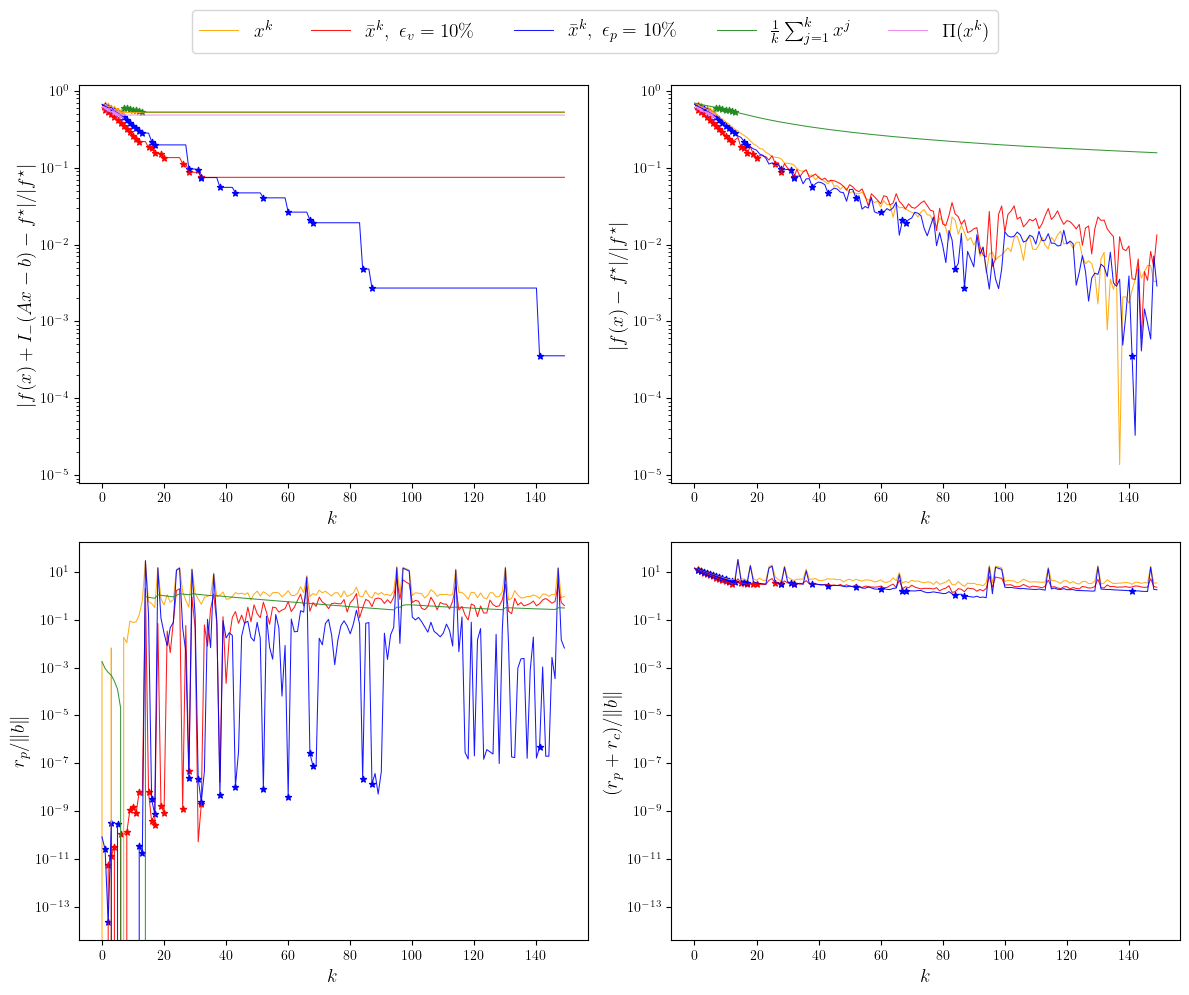

In [9]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, filename, T)